In [1]:
pip install tensorflow matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
import re
import matplotlib.pyplot as plt

# Load and clean Cornell dataset
def load_lines(filepath, limit=5000):
    with open(filepath, encoding='utf-8', errors='ignore') as file:
        lines = file.readlines()
    dialogues = []
    for line in lines[:limit]:  # Limit for speed
        parts = line.split(" +++$+++ ")
        if len(parts) == 5:
            sentence = parts[4].strip()
            cleaned = re.sub(r"[^a-zA-Z0-9\s]", "", sentence.lower())
            dialogues.append(cleaned)
    return dialogues

# Load and prepare data
data_path = "./data/movie_lines.txt"  # make sure path is correct
lines = load_lines(data_path)

# Tokenization
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(lines)

# Create input sequences using n-gram model
input_sequences = []
for line in lines:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(2, len(token_list)):
        n_gram = token_list[:i+1]
        input_sequences.append(n_gram)

# Padding
max_seq_len = 20
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')

# Predictors and label split
input_sequences = np.array(input_sequences)
predictors = input_sequences[:, :-1]
label = input_sequences[:, -1]
label = to_categorical(label, num_classes=vocab_size)

# Build Bi-LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_seq_len - 1))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_seq_len - 1))
model.summary()

# Train the model
history = model.fit(predictors, label, epochs=10, batch_size=64, validation_split=0.2)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 19, 128)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5000)                │       1,285,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,188,168 (8.35 MB)

 Trainable params: 2,188,168 (8.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 36s 62ms/step - accuracy: 0.0362 - loss: 6.9227 - val_accuracy: 0.0381 - val_loss: 6.6398
Epoch 2/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 36s 69ms/step - accuracy: 0.0496 - loss: 6.1547 - val_accuracy: 0.0619 - val_loss: 6.5531
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - accuracy: 0.0709 - loss: 5.7889 - val_accuracy: 0.0743 - val_loss: 6.5376
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.0953 - loss: 5.4420 - val_accuracy: 0.0816 - val_loss: 6.5750
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.1157 - loss: 5.1433 - val_accuracy: 0.0889 - val_loss: 6.6521
Epoch 6/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.1313 - loss: 4.8368 - val_accuracy: 0.0878 - val_loss: 6.7352
Epoch 7/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.1505 - loss: 4.5521 - val_accuracy: 0.0895 - val_loss: 6.8251
Epoch 8/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - accuracy: 0.1773 - loss: 4.2837 - 

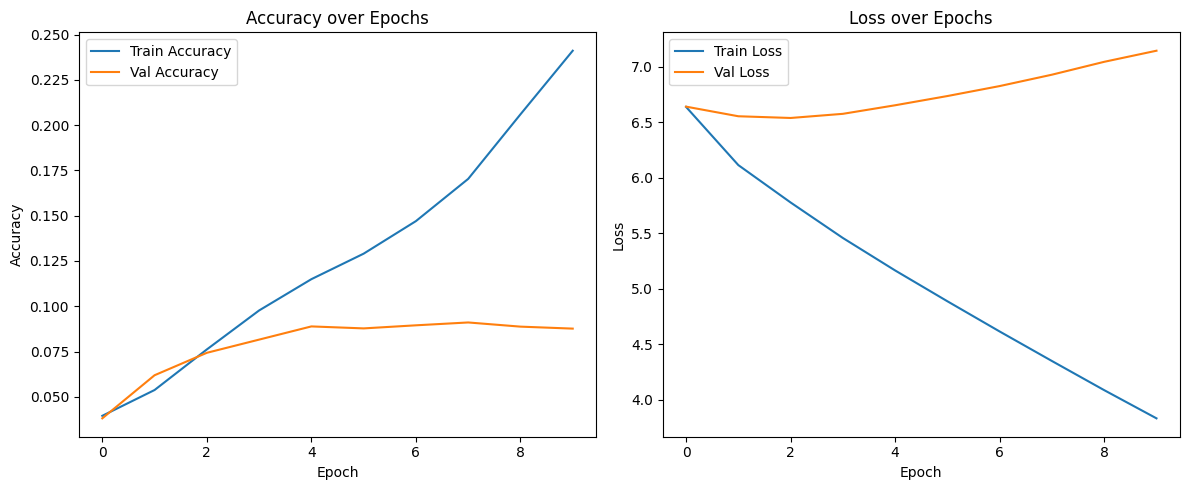

In [5]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Text auto-completion function
def generate_text(seed_text, next_words=20):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len - 1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_index = np.argmax(predicted_probs, axis=-1)[0]
        output_word = tokenizer.index_word.get(predicted_index, '')
        if output_word == '' or output_word == 'endseq':
            break
        seed_text += " " + output_word
    return seed_text

# Test with user input
while True:
    user_input = input("Enter a prompt (or type 'quit'): ").strip()
    if user_input.lower() == 'quit':
        break
    print("Autocomplete:", generate_text(user_input, next_words=20))


Enter a prompt (or type 'quit'): what do you
Autocomplete: what do you think i got to do to do i dont know i got a lot of money i want to get
Enter a prompt (or type 'quit'): I don't know how
Autocomplete: I don't know how you think i got to do to do with you you dont know what i got to work with the
